# BipedalWalker with Twin Delayed DDPG (TD3)

### Paper: https://arxiv.org/abs/1802.09477


### 1. Start the Environment and Agent 

In [1]:
import numpy as np
import torch
import torch.nn as nn
#from torch.autograd import Variable
import torch.nn.functional as F

import gym
#import argparse
import os

import time
# from TwinDelayed import Actor, Critic, ReplayBuffer, TD3
from model import DeterministicActor, QNetwork
from replay_memory import ReplayBuffer,ReplayMemory
from td3_agent import TD3
from collections import deque


In [2]:
start_timestep=1e4

std_noise=0.1

env = gym.make('BipedalWalker-v3')

# Set seeds
seed = 10
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state = env.reset()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

agent = TD3(state_dim, action_dim, max_action,400)


/home/dan/anaconda3/envs/rl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### 2. Traning the agent

In [3]:
# save(agent = agent, filename='checkpnt, directory = 'dir_chkpoint')     
def save(agent, filename, directory):
    torch.save(agent.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(agent.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
    torch.save(agent.actor_target.state_dict(), '%s/%s_actor_t.pth' % (directory, filename))
    torch.save(agent.critic_target.state_dict(), '%s/%s_critic_t.pth' % (directory, filename))   

In [ ]:
# Twin Delayed Deep Deterministic (TD3) policy gradient algorithm
def twin_ddd_train(n_episodes=2000, save_every=100,convergence_check_it = 0,load_scores = False):

    scores_deque = deque(maxlen=100)
    if load_scores:
        scores_array = scores
        avg_scores_array = avg_scores
    else:
        scores_array = []
        avg_scores_array = []    

        
    since_improve = 0
    max_avg = -100000
        
    time_start = time.time()                    # Init start time
    replay_buf = ReplayMemory()                 # Init ReplayBuffer
    
    timestep_after_last_save = 0
    total_timesteps = 0
    
    low = env.action_space.low
    high = env.action_space.high
    
    print('Low in action space: ', low, ', High: ', high, ', Action_dim: ', action_dim)
            
    for i_episode in range(1, n_episodes+1):
        
        timestep = 0
        total_reward = 0
        
        # Reset environment
        state = env.reset()
        done = False
        
        while True:
            
            # Select action randomly or according to policy
            if total_timesteps < start_timestep:
                action = env.action_space.sample()
            else:
                action = agent.select_action(np.array(state))
                if std_noise != 0: 
                    shift_action = np.random.normal(0, std_noise, size=action_dim)
                    action = (action + shift_action).clip(low, high)
            
            # Perform action
            new_state, reward, done, _ = env.step(action) 
            done_bool = 0 if timestep + 1 == env._max_episode_steps else float(done)
            total_reward += reward                          # full episode reward

            # Store every timestep in replay buffer
            replay_buf.push(state,action, reward, new_state, done_bool)
            state = new_state

            timestep += 1     
            total_timesteps += 1
            timestep_after_last_save += 1

            if done:                                       # done ?
                break                                      # save score

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        if avg_score > max_avg:
            max_avg = avg_score
            since_improve = 0
        else:
            since_improve += 1
        # train_by_episode(time_start, i_episode) 
        s = (int)(time.time() - time_start)
        print('Ep. {}, Timestep {},  Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02} '\
                .format(i_episode, total_timesteps, timestep, \
                        total_reward, avg_score, s//3600, s%3600//60, s%60))     

        agent.train(replay_buf, timestep)

        # Save episode if more than save_every=5000 timesteps
#         if timestep_after_last_save >= save_every:

#             timestep_after_last_save %= save_every            
#             save(agent, 'checkpnt_seed_10', 'dir_chk_td3')  
        
        if i_episode % save_every == 0:
            print("saved agent")
            save(agent,'checkpoint_seed%d_it%d_avg%d'%(seed,i_episode,avg_score),'dir_chk_td3')
        if len(scores_deque) == 100 and np.mean(scores_deque) >= 300.5:
            if convergence_check_it == 0:
                print('Environment solved with Average Score: ',  np.mean(scores_deque) )
                break
            else:
                if since_improve > convergence_check_it:
                    print("reached_convergence")
                    break
    

    return scores_array, avg_scores_array

scores, avg_scores = twin_ddd_train(convergence_check_it= 100)
# memory = twin_ddd_train()

Low in action space:  [-1. -1. -1. -1.] , High:  [1. 1. 1. 1.] , Action_dim:  4
Ep. 1, Timestep 56,  Ep.Timesteps 56, Score: -102.79, Avg.Score: -102.79, Time: 00:00:00 
Ep. 2, Timestep 127,  Ep.Timesteps 71, Score: -117.16, Avg.Score: -109.97, Time: 00:00:00 
Ep. 3, Timestep 222,  Ep.Timesteps 95, Score: -100.13, Avg.Score: -106.69, Time: 00:00:01 
Ep. 4, Timestep 1822,  Ep.Timesteps 1600, Score: -84.42, Avg.Score: -101.12, Time: 00:00:02 
Ep. 5, Timestep 1886,  Ep.Timesteps 64, Score: -104.41, Avg.Score: -101.78, Time: 00:00:11 
Ep. 6, Timestep 1956,  Ep.Timesteps 70, Score: -114.89, Avg.Score: -103.97, Time: 00:00:11 
Ep. 7, Timestep 3556,  Ep.Timesteps 1600, Score: -78.25, Avg.Score: -100.29, Time: 00:00:12 
Ep. 8, Timestep 3751,  Ep.Timesteps 195, Score: -123.75, Avg.Score: -103.22, Time: 00:00:20 
Ep. 9, Timestep 5351,  Ep.Timesteps 1600, Score: -74.32, Avg.Score: -100.01, Time: 00:00:22 
Ep. 10, Timestep 6951,  Ep.Timesteps 1600, Score: -89.20, Avg.Score: -98.93, Time: 00:00:31 

Ep. 88, Timestep 20717,  Ep.Timesteps 70, Score: -121.87, Avg.Score: -104.81, Time: 00:02:03 
Ep. 89, Timestep 20775,  Ep.Timesteps 58, Score: -117.72, Avg.Score: -104.95, Time: 00:02:04 
Ep. 90, Timestep 20850,  Ep.Timesteps 75, Score: -127.35, Avg.Score: -105.20, Time: 00:02:04 
Ep. 91, Timestep 20900,  Ep.Timesteps 50, Score: -117.54, Avg.Score: -105.34, Time: 00:02:05 
Ep. 92, Timestep 20948,  Ep.Timesteps 48, Score: -116.66, Avg.Score: -105.46, Time: 00:02:05 
Ep. 93, Timestep 21001,  Ep.Timesteps 53, Score: -118.97, Avg.Score: -105.61, Time: 00:02:05 
Ep. 94, Timestep 21046,  Ep.Timesteps 45, Score: -114.89, Avg.Score: -105.71, Time: 00:02:05 
Ep. 95, Timestep 21132,  Ep.Timesteps 86, Score: -117.50, Avg.Score: -105.83, Time: 00:02:06 
Ep. 96, Timestep 21230,  Ep.Timesteps 98, Score: -121.55, Avg.Score: -105.99, Time: 00:02:06 
Ep. 97, Timestep 21271,  Ep.Timesteps 41, Score: -111.66, Avg.Score: -106.05, Time: 00:02:07 
Ep. 98, Timestep 21325,  Ep.Timesteps 54, Score: -120.05, Av

Ep. 174, Timestep 89748,  Ep.Timesteps 167, Score: -103.14, Avg.Score: -106.88, Time: 00:09:10 
Ep. 175, Timestep 90099,  Ep.Timesteps 351, Score: -110.83, Avg.Score: -106.79, Time: 00:09:11 
Ep. 176, Timestep 91699,  Ep.Timesteps 1600, Score: -116.35, Avg.Score: -107.56, Time: 00:09:14 
Ep. 177, Timestep 93299,  Ep.Timesteps 1600, Score: -70.65, Avg.Score: -107.21, Time: 00:09:23 
Ep. 178, Timestep 93404,  Ep.Timesteps 105, Score: -94.03, Avg.Score: -106.98, Time: 00:09:32 
Ep. 179, Timestep 93466,  Ep.Timesteps 62, Score: -113.58, Avg.Score: -106.92, Time: 00:09:33 
Ep. 180, Timestep 95066,  Ep.Timesteps 1600, Score: -82.93, Avg.Score: -106.61, Time: 00:09:34 
Ep. 181, Timestep 96666,  Ep.Timesteps 1600, Score: -107.43, Avg.Score: -106.55, Time: 00:09:45 
Ep. 182, Timestep 98266,  Ep.Timesteps 1600, Score: -64.05, Avg.Score: -105.94, Time: 00:09:56 
Ep. 183, Timestep 99866,  Ep.Timesteps 1600, Score: -35.10, Avg.Score: -105.16, Time: 00:10:07 
Ep. 184, Timestep 101466,  Ep.Timesteps 

In [5]:
save(agent, 'trained_ok2', 'dir_chk_td3')  

length of scores:  1795 , len of avg_scores:  1795


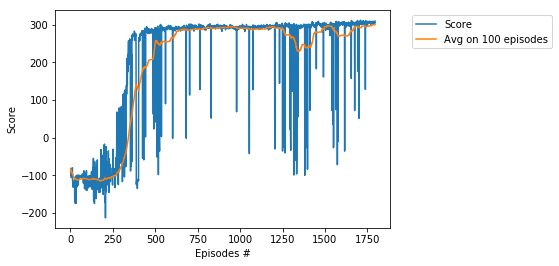

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [7]:
from collections import deque
import os

def play(env, agent, n_episodes):
    state = env.reset()
    
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes+1):
        state = env.reset()        
        score = 0
        
        time_start = time.time()
        
        while True:
            action = agent.select_action(np.array(state))
            env.render()
            next_state, reward, done, _ = env.step(action)
            state = next_state
            score += reward
            if done:
                break 

        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60))  

play(env=env, agent=agent, n_episodes=7)


Episode 1	Average Score: 304.17,	Score: 304.17 	Time: 00:00:16
Episode 2	Average Score: 304.81,	Score: 305.44 	Time: 00:00:12
Episode 3	Average Score: 305.16,	Score: 305.87 	Time: 00:00:12
Episode 4	Average Score: 305.21,	Score: 305.34 	Time: 00:00:12
Episode 5	Average Score: 305.14,	Score: 304.86 	Time: 00:00:12
Episode 6	Average Score: 304.79,	Score: 303.05 	Time: 00:00:13
Episode 7	Average Score: 304.80,	Score: 304.90 	Time: 00:00:12


In [8]:
env.close()